# Aim - Generate input files for the MITgcm runs. 

Generates the basic forcing files for 1km run, can be adapted for any other resolution easily.

The initial conditions were generated with a model snapshot at a lower resolution. Data provided for 1snapshot of 5km run (against github recommendations).

In [1]:
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#  set what resolution model is needed.
res = 1

In [3]:
f = 2* 2*np.pi/(24*3600)*np.sin(-np.pi/180*35)

In [4]:
output_dir = '/swot/SUM05/dbalwada/input_files_channel_sin2_buffer/%02d' %res + 'km_res/'
tp = '>f8'
output_dir

'/swot/SUM05/dbalwada/input_files_channel_sin2_buffer/01km_res/'

# Topography has the form:

$$ -H + h_b = -H + h_0 e^{-x^2/\sigma^2} $$

With $H = 3000$ m, $h_0 = 1000$ m and $\sigma = 75$ km.

The particular numbers are chosen to match Ryan's previous experiments

In [5]:
# A function that makes xy grid
def make_grid_xy(n, length=2e6):
    lx, ly = length, length
    nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [6]:
Lx = 2e6

n = int(Lx/res/1000)

In [8]:
xc, yc = make_grid_xy(n, Lx)

dx = xc[0,1] - xc[0,0]
dy = yc[1,0] - yc[0,0]
print(dx, dy    , len(xc[0,:]))

1000.0 1000.0 2000


In [9]:
H = 3000.0 
h0 = 1000.0
sig = 75.0e3

#bathy = -(H + h)
#bathy = H - h0 * np.exp(-(xc - Lx/2)**2 / sig**2)
bathy =  -(H- h0*np.exp(-(xc - Lx/2)**2 / sig**2))
bathy[0,:] = 0.0

In [8]:
bathy.astype(tp).tofile(output_dir + 'BATHY_3000m_ridge_1000m_75m_wide%03d.bin' % res)

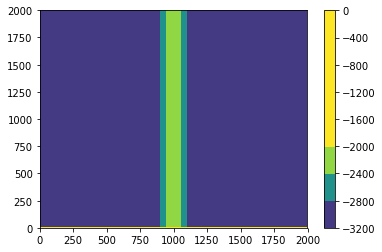

In [10]:
plt.contourf((bathy), vmax = -2000)
plt.colorbar()

(0, 2000)

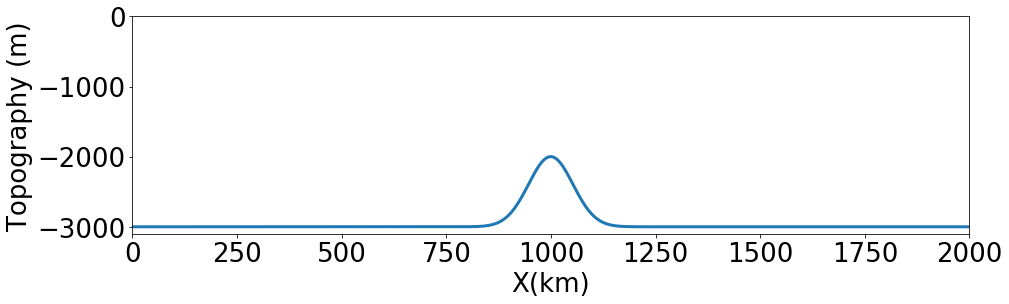

In [17]:
plt.figure(figsize=(15,4))
plt.rcParams['font.size']=26
plt.plot((bathy[10,:]),'-',linewidth=3)
plt.xlabel('X(km)')
plt.ylabel('Topography (m)')
plt.ylim([-3100, 0])
plt.xlim([0, 2000])

## Wind

In [11]:
tau0 = 0.2

# make sure that the northern point has zero winds
tau = np.zeros([n,n])


a =100e3 # the narrowness of the 
L =2000e3
tau = tau0*(np.sin(np.pi* (yc-a/2)/(L-a))**2) # slightly squeezed wind profile to account 

tau[yc<=a/2] = 0.
tau[yc>=(L-a/2)] = 0.

#tau.astype(tp).tofile((output_dir + 'TAU_sin2_with_zeros_for50km_%03d_%03d.bin'%(tau0*1e4,res)))

flag = 0
if flag ==1 :
    plt.pcolor(tau)
    plt.colorbar()

    plt.figure()
    plt.plot(yc[:,n/2],tau[:,n/2],'.')

(-0.01, 0.22)

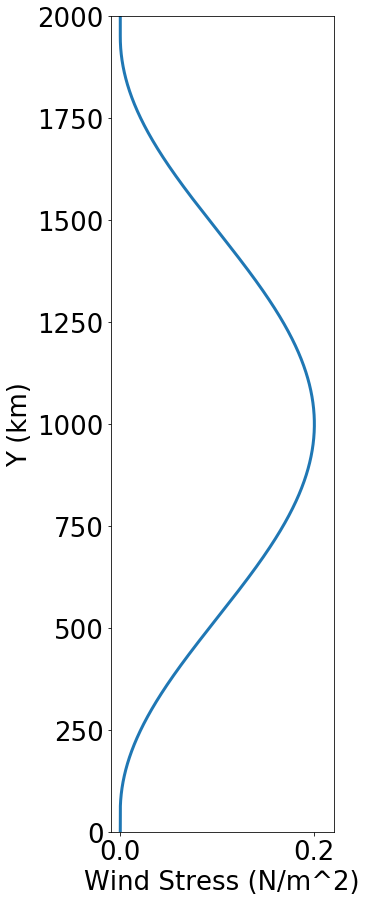

In [13]:
plt.figure(figsize=(4,15))
plt.rcParams['font.size']=26
plt.plot(tau[:,1],yc[:,1]/1000,linewidth=3)
plt.xlabel('Wind Stress (N/m^2)')
plt.ylabel('Y (km)')
plt.ylim([0,2000])
plt.xlim([-0.01, 0.22])

# Surface temperature restoring

In [14]:
Tmin, Tmax = 0., 8.0
Tsurf = np.tile(np.linspace(Tmin, Tmax, n), (n,1)).T

In [ ]:
Tsurf.astype(tp).tofile((output_dir + 'THETA_surf_0to8_linear_%03d.bin' %res))

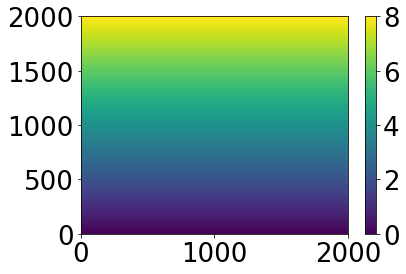

In [15]:
flag = 1
if flag == 1:
    plt.pcolor(Tsurf)
    plt.colorbar()

([<matplotlib.axis.XTick at 0x7f3c667f1358>,
 <a list of 2 Text xticklabel objects>)

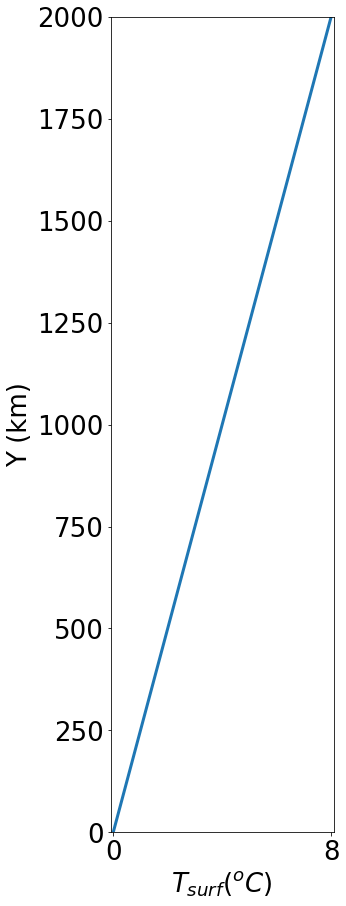

In [16]:
plt.figure(figsize=(4,15))
plt.rcParams['font.size']=26
plt.plot(Tsurf[:,1],yc[:,1]/1000,linewidth=3)
plt.xlabel('$T_{surf} (^oC)$')
plt.ylabel('Y (km)')
plt.ylim([0,2000])
plt.xlim([-0.1, 8.1])
plt.xticks([0,8])

## Interpolating output from another (coarser) run to 1km grid for initial conditions
(including case when vertical resolution changes)

In [17]:
# hard code vertical axis
delR =   np.array([1.00,    1.14,    1.30,    1.49,   1.70,  
                   1.93,    2.20,    2.50,    2.84,   3.21,        
                   3.63,    4.10,    4.61,    5.18,   5.79,   
                   6.47,    7.20,    7.98,    8.83,   9.73,  
                   10.69,   11.70,   12.76,   13.87,  15.03,   
                   16.22,   17.45,   18.70,   19.97,  21.27,    
                   22.56,   23.87,   25.17,   26.46,  27.74,  
                   29.00,   30.24,   31.45,   32.65,  33.82, 
                   34.97,   36.09,   37.20,   38.29,  39.37,   
                   40.45,   41.53,   42.62,   43.73,  44.87,
                   46.05,   47.28,   48.56,   49.93,  51.38,
                   52.93,   54.61,   56.42,   58.38,  60.53,
                   62.87,   65.43,   68.24,   71.33,  74.73,
                   78.47,   82.61,   87.17,   92.21,  97.79,
                   103.96,  110.79,  118.35,  126.73, 136.01, 174.67])

In [18]:
Z = -(delR.cumsum())

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


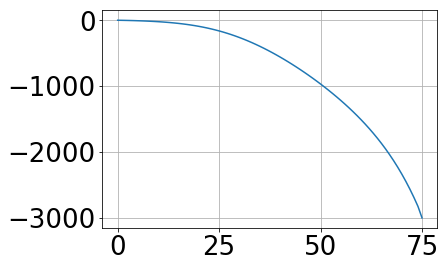

In [19]:
plt.plot(Z)
plt.grid('on')

In [38]:
ds_05 = open_mdsdataset('./5km_snapshot/', iters = [2*5184000],delta_t=300, prefix=['T']
                     ,ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in ./5km_snapshot/. Using default version.
  "in %s. Using default version." % data_dir)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [57]:
plt.rcParams['font.size']=12

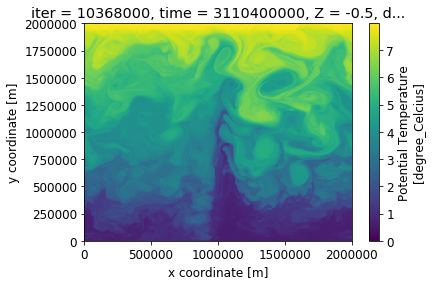

In [58]:
ds_05['T'].isel(Z=0).plot()

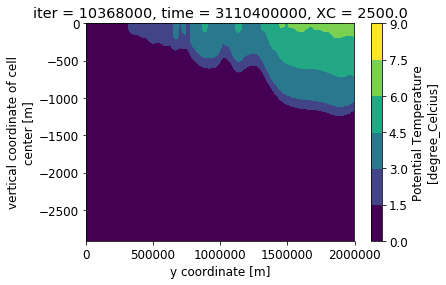

In [59]:
ds_05['T'].isel(XC=0,time=0).plot.contourf()

In [41]:
ds_05_reshaped = ds_05['T'].isel(time=-1).values

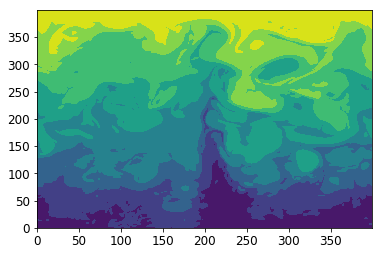

In [60]:
plt.contourf(ds_05_reshaped[0,:,:])

In [45]:
xn, yn = xc, yc       # new grid
xo, yo = np.meshgrid(ds_05.XC.values, ds_05.YC.values) # old grid

In [46]:
xn[-1,-1], xo[-1,-1]

(1999500.0, 1997500.0)

In [47]:
# create an extended matrix
# add extra points to both side of the domain that 
# sit at the farthest edge

xtemp = xo[0,:]
xtemp2 = np.zeros([len(xtemp)+2])
xtemp2[1:(len(xtemp2)-1)] = xtemp
xtemp2[-1] = Lx


ytemp = yo[:,0]
ytemp2 = np.zeros([len(ytemp)+2])
ytemp2[1:(len(ytemp2)-1)] = ytemp
ytemp2[-1]=Lx

xo2, yo2 = np.meshgrid(xtemp2, ytemp2)

In [49]:
hydro_reshaped_pad = np.zeros([76, len(ytemp)+2, len(xtemp)+2])

hydro_reshaped_pad[:,1:len(ytemp)+1,1:len(xtemp)+1] = ds_05_reshaped

hydro_reshaped_pad[:,:,0] = hydro_reshaped_pad[:,:,1]
hydro_reshaped_pad[:,:,-1] = hydro_reshaped_pad[:,:,1]
hydro_reshaped_pad[:,0,:] = hydro_reshaped_pad[:,1,:]
hydro_reshaped_pad[:,-1,:] = hydro_reshaped_pad[:,-3,:]
hydro_reshaped_pad[:,-2,:] = hydro_reshaped_pad[:,-3,:]

In [50]:
hydro_reshaped_pad.shape

(76, 402, 402)

In [51]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
new_temp = np.zeros((76,len(yn[:,0]),len(xn[0,:])))

In [52]:
for klev in range(0, 76):
    
    data = hydro_reshaped_pad[klev,:,:]

    points = np.vstack((yo2.ravel(), xo2.ravel())).T
    values = data.ravel()
    lint = LinearNDInterpolator(points, values)

    new_points = np.vstack((yn.ravel(), xn.ravel())).T

    new_values = lint(new_points)
    
    new_temp[klev,:,:] = new_values.reshape(xn.shape)
    print(klev)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


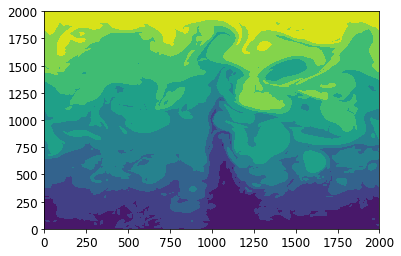

In [61]:
plt.contourf(new_temp[0,:,:])

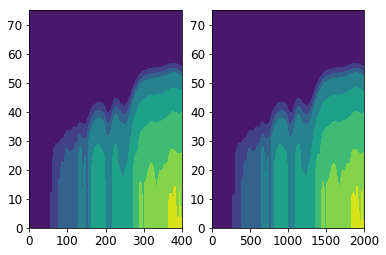

In [62]:
plt.subplot(121)
plt.contourf(ds_05_reshaped[:,:,0])
plt.subplot(122)
plt.contourf(new_temp[:,:,0] )

In [55]:
new_temp.shape

(76, 2000, 2000)

In [56]:
new_temp=new_temp+0.001 # add a little temperature so that no 0 values, since MITgcm does not like absolute 0s. 

In [32]:
new_temp.astype(tp).tofile(output_dir + 'THETA_init_05km_small_lam_start_%03d.bin' % res)

## Make surface tracer forcing.

In [ ]:
rbcs_mask = np.zeros((76,n,n))
rbcs_mask[0,:,:] = 1.
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_mask_%03d.bin' % res)

rbcs_relax = np.zeros((76,n,n))
rbcs_relax[0,:,:] = 1.
rbcs_relax.astype(tp).tofile(output_dir + 'rbcs_relax_%03d.bin' % res)